In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/yry/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1. Preprocess the data

In [3]:
spam = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
spam.columns = ['category', 'content']
spam['label'] = np.where(spam.category == 'spam', 1, 0)
spam.head()

,category,content,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
## Remove the stop words:
def remove_punc_stop(text):
    text = [i for i in text if i not in string.punctuation] # Remove punctuation
    word = "".join(text).split()
    word = [i.lower() for i in word if i.lower() not in stopwords.words("english")] # Change to lower case
    word = " ".join(word)
    return word
  

In [5]:
# Remove the stop words:
spam['processed_content'] = spam.content.apply(remove_punc_stop)
spam.head()

,category,content,label,processed_content
0,ham,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah dont think goes usf lives around though


In [25]:
x = spam['processed_content']
y = spam.label

# 2. Vectorize the data:

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [27]:
count_vec = CountVectorizer()
x = count_vec.fit_transform(x)
x = x.toarray()

In [28]:
x_tr, x_te, y_tr, y_te = train_test_split(x, y, random_state = 256, test_size = 0.3, stratify = y)

# 3. Naïve Bayes models

## 3.1 Gaussian Naiïve Bayes:

In [29]:

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [85]:
class myBayes:
  def __init__(self, model, **kw):
    self.model = model(**kw)

  def __call__(self, x_tr, x_te, y_tr, y_te):
    print('>>>> running')
    self.__x_tr = x_tr
    self.__x_te = x_te
    self.__y_tr = y_tr
    self.__y_te = y_te

    m = self.model
    m.fit(x_tr, y_tr)
    self.tr_pred = m.predict(x_tr)
    self.te_pred = m.predict(x_te)

    # Get the score:
    self.f1_tr = f1_score(y_tr, self.tr_pred)
    self.f1_te = f1_score(y_te, self.te_pred) 
    self.accu_tr = accuracy_score(y_tr, self.tr_pred)
    self.accu_te = accuracy_score(y_te, self.te_pred)

    print('>>>> fitted')

    # Get the confusion matrix:

  def get_confusion_matrix(self, target = 'test'):
    classes = ['ham', 'spam']
    if target == 'test':
      cm = confusion_matrix(self.__y_te, self.te_pred)
    else:
      cm = confusion_matrix(self.__y_tr, self.tr_pred)
    frame = pd.DataFrame(cm, columns = classes, index = classes)
    return frame
  
  def plot_confusion(self, target = 'test'):
    model_name = str(model_name).split('(')[0]
    classes = ['ham', 'spam']
    if target == 'test':
      cm = confusion_matrix(self.__y_te, self.te_pred)
    else:
      cm = confusion_matrix(self.__y_tr, self.tr_pred)

    ## Draw the figure
    fig, ax = plt.subplots(figsize = (6,4))
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix for {}'.format(model_name),
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig('{}_confusion_matrix.png'.format(model.name))
    return ax

    


In [86]:
gnb = myBayes(GaussianNB)
gnb(x_tr, x_te, y_tr, y_te)

>>>> running
>>>> fitted


In [87]:
gnb.get_confusion_matrix()

,ham,spam
ham,1307,141
spam,25,199


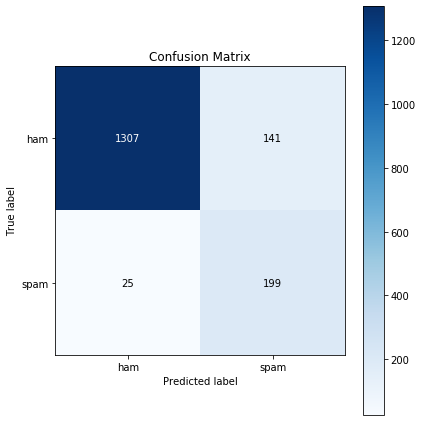

In [78]:
gnb.plot_confusion()
plt.show()

In [70]:
gnb.f1_te, gnb.accu_te

(0.7056737588652483, 0.9007177033492823)

In [84]:
str(gnb.model).split(sep = '(')[0]

'GaussianNB'

## 3.2 Multinomial Naïve Bayes

In [51]:
mnb = myBayes(MultinomialNB)
mnb(x_tr, x_te, y_tr, y_te)

>>>> running
>>>> fitted


In [53]:
mnb.get_confusion_matrix(y_te, mnb.te_pred)

,ham,spam
ham,1415,33
spam,16,208
